#	Sentiment Analysis on Movie Reviews (RNN/LSTM)
## Use IMDB dataset for binary classification (positive vs negative).
## Start with RNN → then improve with LSTM/GRU.
##	Dataset: IMDB (Keras).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns  # optional, for nicer confusion matrix plotting

In [ ]:
# ---------------------------
# Reproducibility
# ---------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# ---------------------------
# Hyperparameters (tweakable)
# ---------------------------
NUM_WORDS = 20000       # only keep top NUM_WORDS most frequent words
MAX_LEN = 200           # max tokens per review (pad/truncate to this)
EMBED_DIM = 128         # embedding dimension
RNN_UNITS = 64          # number of units in the RNN/LSTM/GRU cell
BATCH_SIZE = 128
EPOCHS = 10             # we'll use EarlyStopping so this is a max
N_SPLITS = 5            # K in K-fold cross-validation
L2_REG = 1e-4           # L2 weight regularization (None or float)
VERBOSE = 1

In [ ]:
# ---------------------------
# 1. Load & preprocess IMDB
# ---------------------------
# Using Keras built-in IMDB dataset (already integer-encoded)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

# Pad / truncate sequences to MAX_LEN
x_train = pad_sequences(x_train, maxlen=MAX_LEN)
x_test  = pad_sequences(x_test,  maxlen=MAX_LEN)

print("Shapes:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# -> (25000, MAX_LEN), (25000,), (25000, MAX_LEN), (25000,)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shapes: (25000, 200) (25000,) (25000, 200) (25000,)


In [ ]:
# ---------------------------
# 2. Model builder
#    supports 'simple', 'lstm', 'gru'
# ---------------------------
def build_model(rnn_type='lstm',
                num_words=NUM_WORDS,
                max_len=MAX_LEN,
                embed_dim=EMBED_DIM,
                rnn_units=RNN_UNITS,
                dropout=0.3,
                recurrent_dropout=0.2,
                l2_reg=L2_REG):
    """
    Build and compile a binary classification model using an Embedding layer
    followed by a specified recurrent layer (SimpleRNN, LSTM, or GRU).
    """
    model = Sequential()
    # Embedding converts word indices -> dense vectors
    model.add(Embedding(input_dim=num_words, output_dim=embed_dim, input_length=max_len))

    # Add the chosen recurrent layer
    reg = regularizers.l2(l2_reg) if l2_reg else None
    if rnn_type == 'simple':
        model.add(SimpleRNN(rnn_units,
                            dropout=dropout,
                            recurrent_dropout=recurrent_dropout,
                            kernel_regularizer=reg))
    elif rnn_type == 'lstm':
        model.add(LSTM(rnn_units,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       kernel_regularizer=reg))
    elif rnn_type == 'gru':
        model.add(GRU(rnn_units,
                      dropout=dropout,
                      recurrent_dropout=recurrent_dropout,
                      kernel_regularizer=reg))
    else:
        raise ValueError("rnn_type must be 'simple', 'lstm', or 'gru'")

    # A little dense head and binary output
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=reg))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
# ---------------------------
# 3. K-Fold Cross Validation
#    We perform StratifiedKFold on the training set
# ---------------------------
def run_kfold(rnn_type='lstm', n_splits=N_SPLITS):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    fold_no = 1
    val_accuracies = []
    histories = []  # store history objects if you want to plot later

    for train_index, val_index in skf.split(x_train, y_train):
        print(f"\n--- Fold {fold_no}/{n_splits} ---")
        X_tr, X_val = x_train[train_index], x_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        model = build_model(rnn_type=rnn_type)

        # Callbacks to reduce overfitting
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
        ]

        history = model.fit(X_tr, y_tr,
                            validation_data=(X_val, y_val),
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            callbacks=callbacks,
                            verbose=VERBOSE)

        # store history
        histories.append(history)

        # Evaluate on validation fold
        val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)
        print(f"Fold {fold_no} validation accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")
        val_accuracies.append(val_acc)

        fold_no += 1

    print("\nK-Fold results:")
    for i, acc in enumerate(val_accuracies, 1):
        print(f"  Fold {i}: {acc:.4f}")
    print(f"Mean val accuracy: {np.mean(val_accuracies):.4f}")
    return histories, np.mean(val_accuracies)

# Example: run for Simple RNN first (this is slower)
# histories_simple, mean_acc_simple = run_kfold(rnn_type='simple')


In [ ]:
# ---------------------------
# 4. Train final model & evaluate on test set
#    After CV, we often train on full training data (or best hyperparams) and evaluate once
# ---------------------------
def train_final_and_evaluate(rnn_type='lstm'):
    # Build fresh model
    model = build_model(rnn_type=rnn_type)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]

    # Train on full training set with small validation split for monitoring
    history = model.fit(x_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=0.1,
                        callbacks=callbacks,
                        verbose=VERBOSE)

    # Evaluate on test set
    test_loss, test_acc, test_auc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

    # Predict classes for classification report & confusion matrix
    y_pred_probs = model.predict(x_test, batch_size=512)
    y_pred = (y_pred_probs.ravel() >= 0.5).astype(int)

    print("\nClassification Report (test set):")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (test)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model, history

In [ ]:
 #---------------------------
# 5. Utility: Plot training/validation curves
# ---------------------------
def plot_history(histories, title_prefix=''):
    # histories: list of Keras History objects
    for i, h in enumerate(histories, 1):
        plt.figure(figsize=(12,4))
        # accuracy
        plt.subplot(1,2,1)
        plt.plot(h.history['accuracy'], label='train_acc')
        plt.plot(h.history.get('val_accuracy', []), label='val_acc')
        plt.title(f'{title_prefix} Fold {i} - Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

        # loss
        plt.subplot(1,2,2)
        plt.plot(h.history['loss'], label='train_loss')
        plt.plot(h.history.get('val_loss', []), label='val_loss')
        plt.title(f'{title_prefix} Fold {i} - Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
        plt.show()


--- Fold 1/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 114s 665ms/step - accuracy: 0.6712 - auc: 0.7326 - loss: 0.6087 - val_accuracy: 0.8142 - val_auc: 0.8945 - val_loss: 0.4225 - learning_rate: 0.0010
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 97s 618ms/step - accuracy: 0.8653 - auc: 0.9289 - loss: 0.3469 - val_accuracy: 0.8450 - val_auc: 0.9213 - val_loss: 0.3793 - learning_rate: 0.0010
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 98s 622ms/step - accuracy: 0.9025 - auc: 0.9587 - loss: 0.2648 - val_accuracy: 0.8402 - val_auc: 0.9143 - val_loss: 0.3914 - learning_rate: 0.0010
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9068 - auc: 0.9624 - loss: 0.2525
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
157/157 ━━━━━━━━━━━━━━━━━━━━ 97s 616ms/step - accuracy: 0.9068 - auc: 0.9624 - loss: 0.2525 - val_accuracy: 0.8402 - val_auc: 0.9140 - val_loss: 0.4257 - learning_rate: 0.0010
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 97s 618ms/step - accuracy: 0.9356 - auc: 0.9

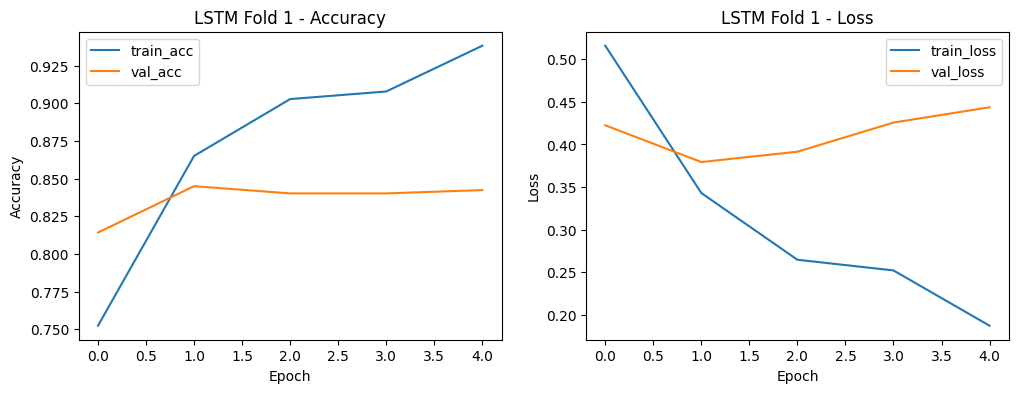

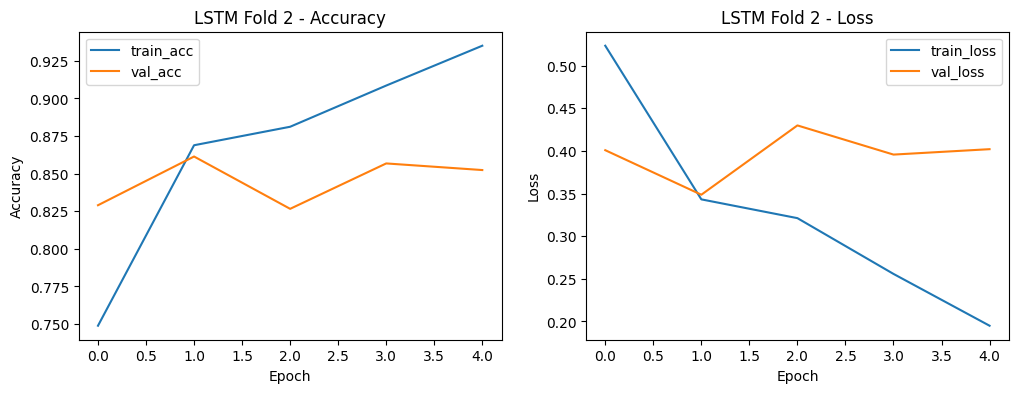

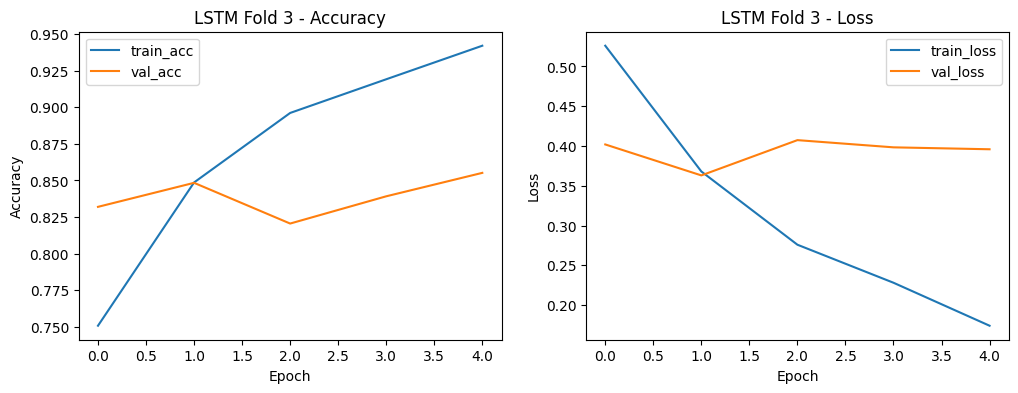

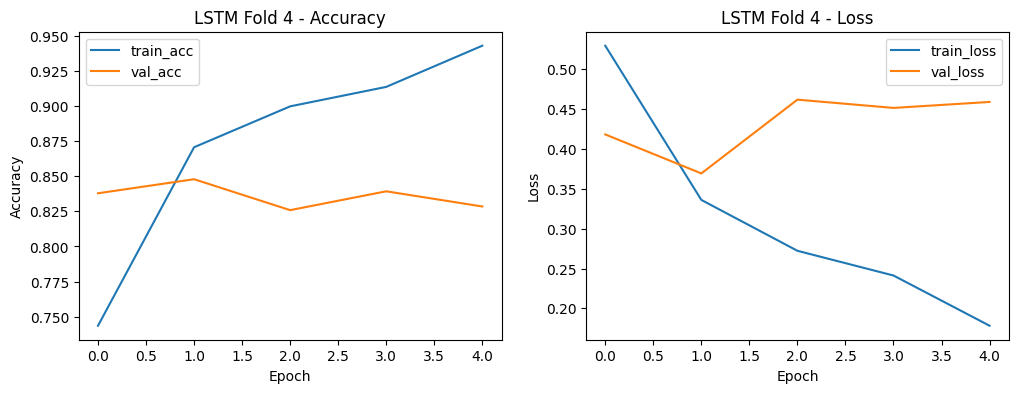

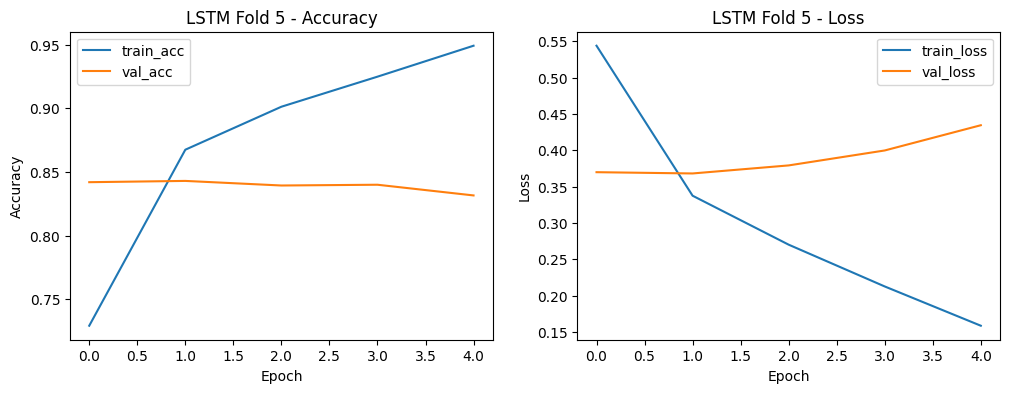

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 603ms/step - accuracy: 0.6719 - auc: 0.7312 - loss: 0.6131 - val_accuracy: 0.8128 - val_auc: 0.8954 - val_loss: 0.4305 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 600ms/step - accuracy: 0.8487 - auc: 0.9203 - loss: 0.3665 - val_accuracy: 0.8260 - val_auc: 0.9092 - val_loss: 0.3972 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 595ms/step - accuracy: 0.8961 - auc: 0.9538 - loss: 0.2813 - val_accuracy: 0.8676 - val_auc: 0.9362 - val_loss: 0.3642 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 106s 602ms/step - accuracy: 0.9181 - auc: 0.9663 - loss: 0.2377 - val_accuracy: 0.8600 - val_auc: 0.9292 - val_loss: 0.3740 - learning_rate: 0.0010
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9293 - auc: 0.9743 - loss: 0.2071
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
176/176 ━━━━━━━━━━━━━━━━━━━━ 106s 601ms/step - accuracy: 0.9292 - auc:

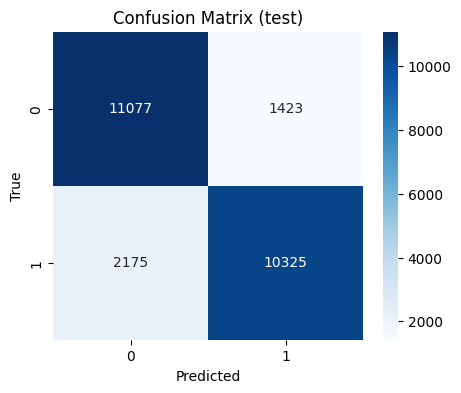

In [ ]:
# ---------------------------
# 6. How to run experiments:
#    - Try rnn_type = 'simple', 'lstm', 'gru'
#    - For faster debugging use smaller N_SPLITS or EPOCHS
# ---------------------------

# Example run:
# (A) Run 5-fold CV for LSTM
histories_lstm, mean_acc_lstm = run_kfold(rnn_type='lstm', n_splits=5)

# Plot per-fold learning curves (optional)
plot_history(histories_lstm, title_prefix='LSTM')

# (B) Train final LSTM on full training set and evaluate on the test set
final_model, final_history = train_final_and_evaluate(rnn_type='lstm')

In [ ]:
# -------------------------------
# 1. Import Libraries
# -------------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

# -------------------------------
# 2. Load and Preprocess Data
# -------------------------------
# Limit to top 10,000 words
max_features = 10000
max_len = 200  # cut reviews after 200 words

# Load dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pad sequences to ensure equal length
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# -------------------------------
# 3. Build LSTM Model
# -------------------------------
def build_lstm():
    model = Sequential([
        Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(
            32,
            dropout=0.3,              # Dropout on input
            recurrent_dropout=0.3,    # Dropout on recurrent connections
            kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
        )),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# -------------------------------
# 4. Cross Validation (3-fold)
# -------------------------------
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_train), 1):
    print(f"\n🔹 Training fold {fold}...")
    X_train_fold, X_val_fold = x_train[train_idx], x_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = build_lstm()

    # Early stopping to reduce overfitting
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=1, restore_best_weights=True
    )

    model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=5,
        batch_size=128,
        verbose=1,
        callbacks=[early_stop]
    )

    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(val_acc)

print("\n✅ Cross-validation accuracies:", fold_accuracies)
print("🎯 Mean CV accuracy:", np.mean(fold_accuracies))

# -------------------------------
# 5. Final Training on Full Data
# -------------------------------
lstm_model = build_lstm()
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=1, restore_best_weights=True
)

lstm_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=128,
    verbose=1,
    callbacks=[early_stop]
)

# -------------------------------
# 6. Evaluate on Test Set
# -------------------------------
y_pred_probs = lstm_model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\n📊 Classification Report (LSTM Test Set):")
print(classification_report(y_test, y_pred))



🔹 Training fold 1...
Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5711 - loss: 0.8687 - val_accuracy: 0.7997 - val_loss: 0.5059
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8109 - loss: 0.4753 - val_accuracy: 0.8086 - val_loss: 0.4499
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.8647 - loss: 0.3769 - val_accuracy: 0.8011 - val_loss: 0.4577

🔹 Training fold 2...
Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5538 - loss: 0.8719 - val_accuracy: 0.7919 - val_loss: 0.5055
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8126 - loss: 0.4761 - val_accuracy: 0.8147 - val_loss: 0.4426
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8560 - loss: 0.3794 - val_accuracy: 0.7985 - val_loss: 0.4628

🔹 Training fold 3...
Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.5832 - loss: 0.8621 - val_accuracy: 0.8165 - val_loss: 0.4750
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Predict probabilities on test set
y_pred_probs = lstm_model.predict(x_test)

# First 5 probabilities
print("First 5 prediction probabilities:", y_pred_probs[:5].flatten())


782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 214ms/step
First 5 prediction probabilities: [0.19168481 0.9429372  0.8126844  0.1423061  0.97656065]


In [ ]:
# Convert probabilities to binary labels (0 = negative, 1 = positive)
y_pred = (y_pred_probs > 0.5).astype(int)

# First 20 predictions vs true labels
print("Predicted labels:", y_pred[:20].flatten())
print("True labels     :", y_test[:20])


Predicted labels: [0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0]
True labels     : [0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🔹 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     12500
           1       0.82      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000


🔹 Confusion Matrix:
[[10283  2217]
 [ 2122 10378]]


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -------------------------------
# Load word index used for training
# -------------------------------
word_index = imdb.get_word_index()

# Parameters (must match your training)
max_len = 200  # same as used in model


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# -------------------------------
# Function to encode custom review
# -------------------------------
def encode_review(text):
    # Convert words to integers based on IMDB word index
    tokens = [word_index.get(word, 2) for word in text.lower().split()]  # 2 = OOV token
    # Pad sequence to max_len
    return pad_sequences([tokens], maxlen=max_len)


In [ ]:
# -------------------------------
# Input a custom review
# -------------------------------
sample_review = "The movie was absolutely amazing, I loved the story and acting."
encoded_review = encode_review(sample_review)

# Predict using your trained LSTM model
pred_prob = lstm_model.predict(encoded_review)[0][0]
pred_label = "Positive" if pred_prob > 0.5 else "Negative"

print("Review:", sample_review)
print("Prediction Probability:", pred_prob)
print("Predicted Sentiment:", pred_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
Review: The movie was absolutely amazing, I loved the story and acting.
Prediction Probability: 0.04749922
Predicted Sentiment: Negative
